<a href="https://colab.research.google.com/github/Anantika0410/Mini-Project/blob/main/test5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install wfdb and compatible pandas
!pip install pandas==2.2.3 wfdb --upgrade --quiet

# Download normal and abnormal ECG files
!wget -q -O 100.dat https://physionet.org/files/mitdb/1.0.0/100.dat?download
!wget -q -O 100.hea https://physionet.org/files/mitdb/1.0.0/100.hea?download

!wget -q -O 105.dat https://physionet.org/files/mitdb/1.0.0/105.dat?download
!wget -q -O 105.hea https://physionet.org/files/mitdb/1.0.0/105.hea?download


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load records
record_normal = wfdb.rdrecord('100')
record_abnormal = wfdb.rdrecord('105')

# Take channel 0
signal_normal = record_normal.p_signal[:, 0]
signal_abnormal = record_abnormal.p_signal[:, 0]

# Split into windows
window_size = 140

def split_into_windows(signal, label):
    X, y = [], []
    for i in range(0, len(signal) - window_size, window_size):
        segment = signal[i:i+window_size]
        X.append(segment)
        y.append(label)
    return np.array(X), np.array(y)

X_normal, y_normal = split_into_windows(signal_normal, 0)
X_abnormal, y_abnormal = split_into_windows(signal_abnormal, 1)

# Combine
X = np.concatenate((X_normal, X_abnormal), axis=0)
y = np.concatenate((y_normal, y_abnormal), axis=0)

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")


Training samples: (7427, 140, 1), Testing samples: (1857, 140, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

# Build CNN-LSTM feature extractor
feature_extractor = Sequential()

feature_extractor.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(140, 1)))
feature_extractor.add(MaxPooling1D(pool_size=2))
feature_extractor.add(Dropout(0.3))

feature_extractor.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
feature_extractor.add(MaxPooling1D(pool_size=2))
feature_extractor.add(Dropout(0.3))

feature_extractor.add(LSTM(64, return_sequences=False))
feature_extractor.add(Dropout(0.3))

# No Dense layer, no softmax/sigmoid layer!

feature_extractor.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 138, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 69, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 69, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 67, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,360 (153.75 KB)

 Trainable params: 39,360 (153.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Extract features from CNN-LSTM
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

print(f"Feature shape: {X_train_features.shape}")


233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Feature shape: (7427, 64)


SVM Test Accuracy: 0.7884
Confusion Matrix:
 [[837 111]
 [282 627]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81       948
           1       0.85      0.69      0.76       909

    accuracy                           0.79      1857
   macro avg       0.80      0.79      0.79      1857
weighted avg       0.80      0.79      0.79      1857



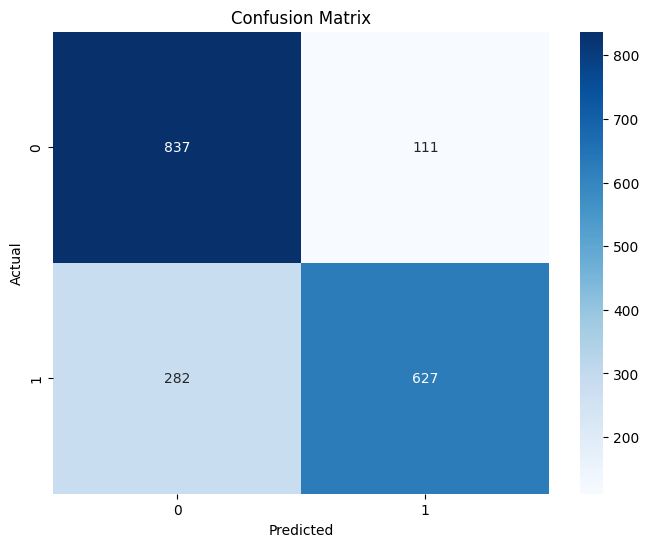

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize SVM
svm_model = SVC(kernel='rbf')  # You can also try 'linear' or 'poly'

# Train SVM
svm_model.fit(X_train_features, y_train)

# Predict
y_pred = svm_model.predict(X_test_features)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Test Accuracy: {accuracy:.4f}")

# Confusion Matrix and Report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
